### Assignment 7

In [24]:
#Imports
from __future__ import print_function
from tqdm import tqdm

import argparse
import os
import random
import torch
import torch.nn as nn

import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
import shutil
from torchvision.utils import save_image


In [3]:
# Root directory for dataset
dataroot = "data/celeba"
workers = 2
batch_size = 256
channels = 3
latent_dim = 100
ngf = 64
ndf = 64
num_epochs = 10

# Learning rate for optimizers
lr = 0.0002

In [4]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [5]:
class Generator(nn.Module):
    def __init__(self,image_size):
        super(Generator, self).__init__()
        self.image_size=image_size
        if(image_size==32):
            self.main = nn.Sequential(
                # input is Z, going into a convolution
                nn.ConvTranspose2d( latent_dim, ngf * 4, 4, 1, 0, bias=False),
                nn.BatchNorm2d(ngf * 4),
                nn.ReLU(True),
                # state size. (ngf*4) x 4 x 4
                nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
                nn.BatchNorm2d(ngf * 2),
                nn.ReLU(True),
                # state size. (ngf*2) x 8 x 8
                nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
                nn.BatchNorm2d(ngf),
                nn.ReLU(True),
                # state size. (ngf) x 16 x 16
                nn.ConvTranspose2d( ngf , channels, 4, 2, 1, bias=False),
                nn.Tanh())
                # state size. (channels) x 32 x 32        
        else:
            self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( latent_dim, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, channels, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (channels) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [6]:
class Discriminator(nn.Module):
    def __init__(self,image_size):
        super(Discriminator, self).__init__()
        self.image_size=image_size
        if(image_size==32):
            self.main = nn.Sequential(
                # input is (channels) x 64 x 64
                nn.Conv2d(channels, ndf, 4, 2, 1, bias=False),
                nn.LeakyReLU(0.2, inplace=True),
                # state size. (ndf) x 32 x 32
                nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
                nn.BatchNorm2d(ndf * 2),
                nn.LeakyReLU(0.2, inplace=True),
                # state size. (ndf*2) x 16 x 16
                nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
                nn.BatchNorm2d(ndf * 4),
                nn.LeakyReLU(0.2, inplace=True),
                # state size. (ndf*4) x 8 x 8
                nn.Conv2d(ndf *4 , 1 , 4, 1, 0, bias=False),
                nn.Sigmoid()
            )
        else:
            self.main = nn.Sequential(
            # input is (channels) x 64 x 64
            nn.Conv2d(channels, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
        

    def forward(self, input):
        return self.main(input)

In [10]:
def train(image_size,writer):
    # We can use an image folder dataset the way we have it setup.
    # Create the dataset
    dataset = dset.ImageFolder(root=dataroot,
                               transform=transforms.Compose([
                                   transforms.Resize(image_size),
                                   transforms.CenterCrop(image_size),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                               ]))
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                             shuffle=True, num_workers=workers)
    device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

    netG = Generator(image_size).to(device)

    netG.apply(weights_init)
    
    netD = Discriminator(image_size).to(device)

    netD.apply(weights_init)
    
    # Initialize BCELoss function
    criterion = nn.BCELoss()

    # Create batch of latent vectors that we will use to visualize
    #  the progression of the generator
    fixed_noise = torch.randn(64, latent_dim, 1, 1, device=device)

    # Establish convention for real and fake labels during training
    real_label = 1.
    fake_label = 0.

    optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))
    optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))
    
    img_list = []
    G_losses = []
    D_losses = []
    iters = 0

    for epoch in range(num_epochs):
        # For each batch in the dataloader
        for i, data in enumerate(dataloader, 0):
            ## Train with all-real batch
            netD.zero_grad()
            # Format batch
            real_cpu = data[0].to(device)
            b_size = real_cpu.size(0)
            label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
            # Forward pass real batch through D
            output = netD(real_cpu).view(-1)
            # Calculate loss on all-real batch
            errD_real = criterion(output, label)
            # Calculate gradients for D in backward pass
            errD_real.backward()
            D_x = output.mean().item()

            ## Train with all-fake batch
            # Generate batch of latent vectors
            noise = torch.randn(b_size, latent_dim, 1, 1, device=device)
            # Generate fake image batch with G
            fake = netG(noise)
            label.fill_(fake_label)
            # Classify all fake batch with D
            output = netD(fake.detach()).view(-1)
            # Calculate D's loss on the all-fake batch
            errD_fake = criterion(output, label)
            # Calculate the gradients for this batch, accumulated (summed) with previous gradients
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            # Compute error of D as sum over the fake and the real batches
            errD = errD_real + errD_fake
            # Update D
            optimizerD.step()

            netG.zero_grad()
            label.fill_(real_label)  # fake labels are real for generator cost
            # Since we just updated D, perform another forward pass of all-fake batch through D
            output = netD(fake).view(-1)
            # Calculate G's loss based on this output
            errG = criterion(output, label)
            # Calculate gradients for G
            errG.backward()
            D_G_z2 = output.mean().item()
            # Update G
            optimizerG.step()           
            writer.add_scalar(f'Loss/Discriminator Loss', errD.item(), global_step=iters)
            writer.add_scalar(f'Loss/Generator Loss', errG.item(), global_step=iters)
            writer.add_scalars(f'Comb_Loss/Losses', {
                                'Discriminator': errD.item(),
                                'Generator':  errG.item()
                            }, iters)  
            # Output training stats
            if i % 50 == 0:
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f'
                      % (epoch, num_epochs, i, len(dataloader),
                         errD.item(), errG.item(), D_x))

            # Save Losses for plotting later
            G_losses.append(errG.item())
            D_losses.append(errD.item())

            # Check how the generator is doing by saving G's output on fixed_noise
            if (iters % 100 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
                with torch.no_grad():
                    fake = netG(fixed_noise).detach().cpu()
                img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
                writer.add_image('images', vutils.make_grid(fake, padding=2, normalize=True), global_step=iters)

            iters += 1
    return G_losses,D_losses,img_list

In [17]:
GAN_LOGS = os.path.join(os.getcwd(), "tboard_logs", "gan32")
if not os.path.exists(GAN_LOGS):
    os.makedirs(GAN_LOGS)
shutil.rmtree(GAN_LOGS)
writer = SummaryWriter(GAN_LOGS)

if not os.path.exists("imgs1"):
    os.makedirs("imgs1")

if not os.path.exists("imgs1/training1"):
    os.makedirs("imgs1/training1")
shutil.rmtree("imgs1/training1")

shutil.rmtree(GAN_LOGS)
writer = SummaryWriter(GAN_LOGS)

### Training the model using 3 * 32 * 32 images

In [18]:
image_size=32
G_losses,D_losses,img_list=train(image_size,writer)

[0/10][0/792]	Loss_D: 1.2444	Loss_G: 2.0404	D(x): 0.4937
[0/10][50/792]	Loss_D: 0.0841	Loss_G: 6.2434	D(x): 0.9651
[0/10][100/792]	Loss_D: 0.0593	Loss_G: 6.3577	D(x): 0.9692
[0/10][150/792]	Loss_D: 0.5220	Loss_G: 8.3100	D(x): 0.9418
[0/10][200/792]	Loss_D: 0.3175	Loss_G: 3.4339	D(x): 0.8910
[0/10][250/792]	Loss_D: 0.4889	Loss_G: 3.4391	D(x): 0.8144
[0/10][300/792]	Loss_D: 0.4767	Loss_G: 2.3654	D(x): 0.8359
[0/10][350/792]	Loss_D: 0.7400	Loss_G: 4.9095	D(x): 0.8922
[0/10][400/792]	Loss_D: 0.4248	Loss_G: 3.4197	D(x): 0.7997
[0/10][450/792]	Loss_D: 0.6841	Loss_G: 3.0663	D(x): 0.7058
[0/10][500/792]	Loss_D: 0.4321	Loss_G: 2.7121	D(x): 0.7822
[0/10][550/792]	Loss_D: 1.0087	Loss_G: 4.1302	D(x): 0.9257
[0/10][600/792]	Loss_D: 0.5971	Loss_G: 3.1713	D(x): 0.8312
[0/10][650/792]	Loss_D: 0.5392	Loss_G: 2.7542	D(x): 0.7446
[0/10][700/792]	Loss_D: 0.7587	Loss_G: 3.1836	D(x): 0.7993
[0/10][750/792]	Loss_D: 0.9046	Loss_G: 1.4852	D(x): 0.5260
[1/10][0/792]	Loss_D: 0.5620	Loss_G: 2.2768	D(x): 0.7309
[1

[8/10][600/792]	Loss_D: 0.8744	Loss_G: 2.7079	D(x): 0.8227
[8/10][650/792]	Loss_D: 1.0387	Loss_G: 1.6029	D(x): 0.5285
[8/10][700/792]	Loss_D: 0.8256	Loss_G: 1.4173	D(x): 0.6784
[8/10][750/792]	Loss_D: 0.8088	Loss_G: 1.6545	D(x): 0.7083
[9/10][0/792]	Loss_D: 0.7576	Loss_G: 1.8575	D(x): 0.7434
[9/10][50/792]	Loss_D: 0.7669	Loss_G: 1.6728	D(x): 0.6894
[9/10][100/792]	Loss_D: 0.8364	Loss_G: 1.4223	D(x): 0.6296
[9/10][150/792]	Loss_D: 1.0414	Loss_G: 0.8810	D(x): 0.4550
[9/10][200/792]	Loss_D: 0.6061	Loss_G: 2.0072	D(x): 0.7384
[9/10][250/792]	Loss_D: 0.8580	Loss_G: 0.9860	D(x): 0.5650
[9/10][300/792]	Loss_D: 0.6578	Loss_G: 1.8472	D(x): 0.7444
[9/10][350/792]	Loss_D: 0.7050	Loss_G: 1.7393	D(x): 0.6992
[9/10][400/792]	Loss_D: 0.9712	Loss_G: 0.7078	D(x): 0.4808
[9/10][450/792]	Loss_D: 0.8143	Loss_G: 0.9390	D(x): 0.5734
[9/10][500/792]	Loss_D: 2.2904	Loss_G: 0.3390	D(x): 0.1447
[9/10][550/792]	Loss_D: 0.7740	Loss_G: 1.3953	D(x): 0.6526
[9/10][600/792]	Loss_D: 0.8240	Loss_G: 0.9497	D(x): 0.5842


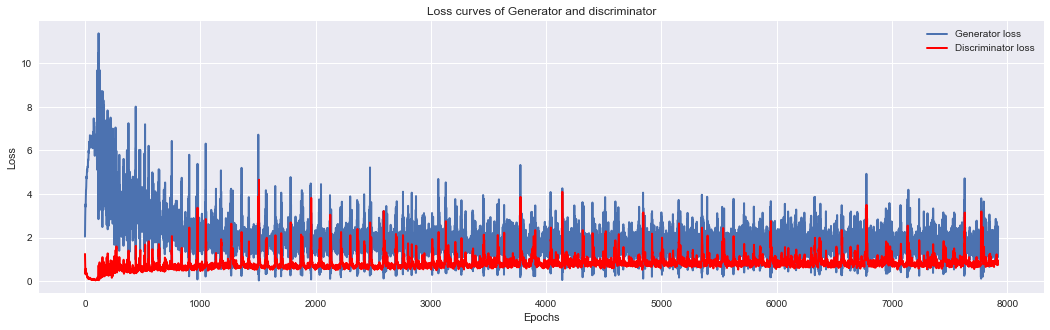

In [21]:
plt.style.use('seaborn')
fig, ax = plt.subplots(1,1)
fig.set_size_inches(18, 5)

ax.plot(G_losses, label="Generator loss", linewidth=2)
ax.plot(D_losses, label="Discriminator loss", c='red', linewidth=2)
ax.legend(loc='best')
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")

ax.set_title("Loss curves of Generator and discriminator")

plt.show()

### Visualizing real vs fake images generated using image size as 3 * 32 * 32

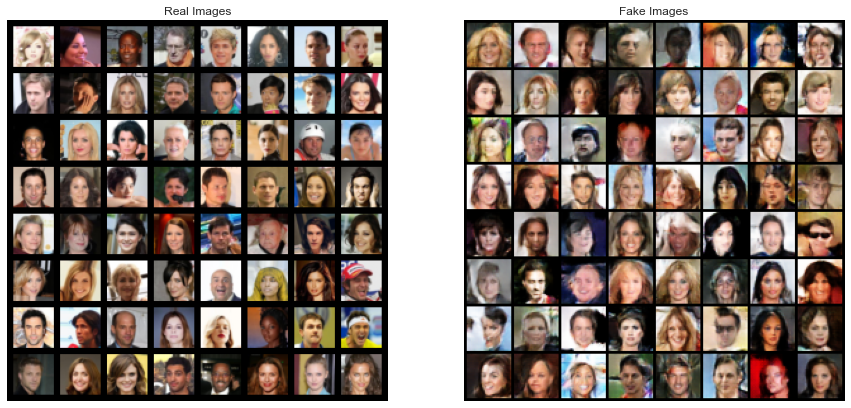

In [22]:
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(32),
                               transforms.CenterCrop(32),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)
real_batch = next(iter(dataloader))

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to('cuda')[:64], padding=5, normalize=True).cpu(),(1,2,0)))

plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

#### Images generated are not that great. They somewhat look like faces but are rather distorted. We go on to train a model using 3 * 64 * 64 image dimensions

### Training the model using 3 * 64 * 64 images

In [11]:
GAN_LOGS1 = os.path.join(os.getcwd(), "tboard_logs", "gan64")
if not os.path.exists(GAN_LOGS1):
    os.makedirs(GAN_LOGS1)
shutil.rmtree(GAN_LOGS1)
writer1 = SummaryWriter(GAN_LOGS1)

if not os.path.exists("imgs/training"):
    os.makedirs("imgs/training")
shutil.rmtree("imgs/training")
writer1 = SummaryWriter(GAN_LOGS1)

In [12]:
image_size=64
G_losses64,D_losses64,img_list64=train(image_size,writer1)

[0/10][0/792]	Loss_D: 1.5915	Loss_G: 6.0948	D(x): 0.6241
[0/10][50/792]	Loss_D: 0.3077	Loss_G: 9.7147	D(x): 0.8849
[0/10][100/792]	Loss_D: 0.2886	Loss_G: 4.4483	D(x): 0.9239
[0/10][150/792]	Loss_D: 1.5635	Loss_G: 1.3366	D(x): 0.3484
[0/10][200/792]	Loss_D: 0.5282	Loss_G: 4.9155	D(x): 0.7765
[0/10][250/792]	Loss_D: 0.5020	Loss_G: 2.7412	D(x): 0.7627
[0/10][300/792]	Loss_D: 0.5521	Loss_G: 4.1657	D(x): 0.8988
[0/10][350/792]	Loss_D: 0.5528	Loss_G: 4.8717	D(x): 0.8834
[0/10][400/792]	Loss_D: 0.4713	Loss_G: 3.6495	D(x): 0.7290
[0/10][450/792]	Loss_D: 0.7463	Loss_G: 6.0103	D(x): 0.9101
[0/10][500/792]	Loss_D: 0.6701	Loss_G: 4.5570	D(x): 0.8543
[0/10][550/792]	Loss_D: 0.6337	Loss_G: 3.8999	D(x): 0.6526
[0/10][600/792]	Loss_D: 0.4437	Loss_G: 5.1665	D(x): 0.8937
[0/10][650/792]	Loss_D: 0.5292	Loss_G: 3.9524	D(x): 0.7853
[0/10][700/792]	Loss_D: 0.5964	Loss_G: 2.1828	D(x): 0.6693
[0/10][750/792]	Loss_D: 0.2897	Loss_G: 4.2068	D(x): 0.8845
[1/10][0/792]	Loss_D: 0.6763	Loss_G: 2.7302	D(x): 0.6785
[1

[8/10][600/792]	Loss_D: 1.9757	Loss_G: 0.9346	D(x): 0.2038
[8/10][650/792]	Loss_D: 0.6538	Loss_G: 1.4105	D(x): 0.6248
[8/10][700/792]	Loss_D: 1.5713	Loss_G: 3.4204	D(x): 0.9185
[8/10][750/792]	Loss_D: 1.1120	Loss_G: 0.6436	D(x): 0.3960
[9/10][0/792]	Loss_D: 0.7333	Loss_G: 1.4063	D(x): 0.5739
[9/10][50/792]	Loss_D: 1.0330	Loss_G: 4.0710	D(x): 0.9300
[9/10][100/792]	Loss_D: 0.7546	Loss_G: 1.2068	D(x): 0.5730
[9/10][150/792]	Loss_D: 0.7583	Loss_G: 3.9136	D(x): 0.9329
[9/10][200/792]	Loss_D: 0.5404	Loss_G: 2.5229	D(x): 0.8358
[9/10][250/792]	Loss_D: 1.0534	Loss_G: 3.1166	D(x): 0.8908
[9/10][300/792]	Loss_D: 0.7821	Loss_G: 3.6110	D(x): 0.9249
[9/10][350/792]	Loss_D: 0.8671	Loss_G: 1.2505	D(x): 0.5182
[9/10][400/792]	Loss_D: 1.1530	Loss_G: 0.7498	D(x): 0.3840
[9/10][450/792]	Loss_D: 1.3179	Loss_G: 4.1911	D(x): 0.9405
[9/10][500/792]	Loss_D: 0.6594	Loss_G: 1.5323	D(x): 0.6171
[9/10][550/792]	Loss_D: 0.9518	Loss_G: 1.9431	D(x): 0.6432
[9/10][600/792]	Loss_D: 0.6532	Loss_G: 2.3116	D(x): 0.8241


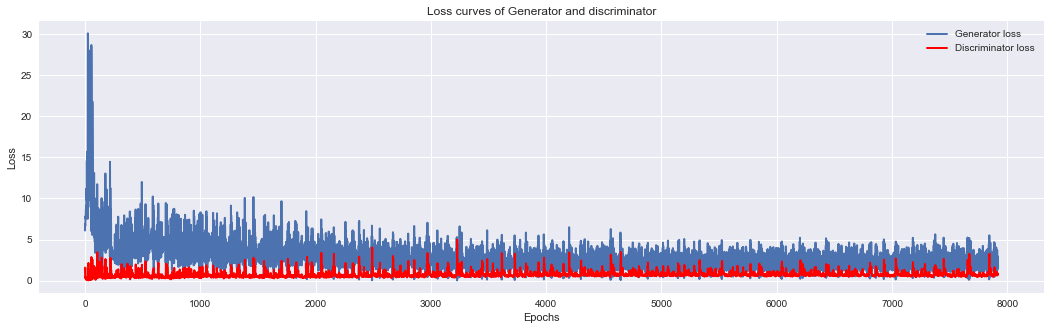

In [20]:
plt.style.use('seaborn')
fig, ax = plt.subplots(1,1)
fig.set_size_inches(18, 5)

ax.plot(G_losses64, label="Generator loss", linewidth=2)
ax.plot(D_losses64, label="Discriminator loss", c='red', linewidth=2)
ax.legend(loc='best')
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")

ax.set_title("Loss curves of Generator and discriminator")

plt.show()

### Visualizing real vs fake images generated using 3 * 64 * 64 images

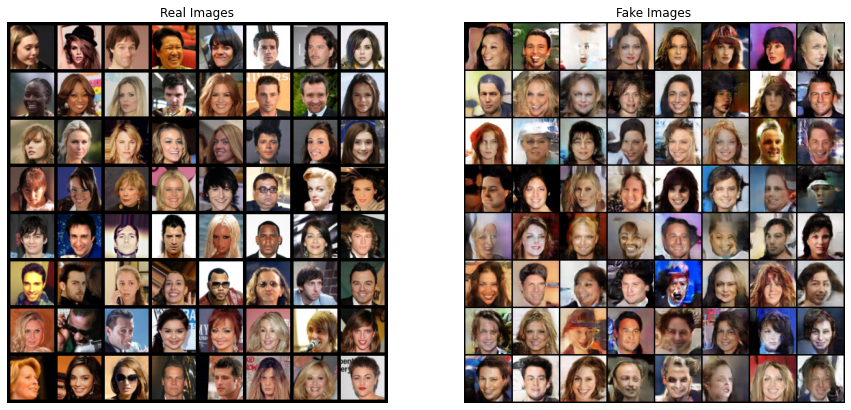

In [15]:
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.CenterCrop(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)
real_batch = next(iter(dataloader))

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to('cuda')[:64], padding=5, normalize=True).cpu(),(1,2,0)))

plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list64[-1],(1,2,0)))
plt.show()

#### Comparison between the two trainings
If we compare images generated using image dimensionality as 3 * 64 * 64 with those generated using 3 * 32 *32 images, we see that images generated using the former are  significantly better than the latter. <br>
If we go on to compare the training losses, we can clearly see that training using 3 * 6 * 64 images is much stable than the other. This is ofcourse as expected.

#### References
https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html